# July 2023 BDC Fabric Challenge Update

This is a work of the Broadband Commons. More of our work can be found [here](https://bbcommons.org/).

## Housekeeping and getting ready

In [2]:
!python.exe -m pip install --upgrade pip
%pip install -r requirements.txt > output.txt
import requests, pathlib, itables, zipfile, json, io
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from pprint import pprint

Note: you may need to restart the kernel to use updated packages.


## 

## Download and prep

The dataset we are downloading is the challenges that were resolved in July 2023 for all of the states where data is available.

Details of these files can be found [here](https://us-fcc.app.box.com/v/bdc-data-downloads-output) (and a copy is included in this repository) on page 71. 

In [3]:
url = 'https://broadbandmap.fcc.gov/nbm/map/api/getChallengeDownloadList/2/2023-07-31'
s = requests.Session()
s.headers.update({'User-Agent': 'challenge-explorer 0.0.1'})

r = s.get(url)

In [4]:
files = json.loads(r.content)

In [5]:
df = pd.DataFrame()
dfColumnHints = {
    "location_id": "Int64",
    "zip_code": "Int64"
}

len(files['data'])

#for file in tqdm(files['data']):
for file in files['data']:
    url = f'https://broadbandmap.fcc.gov/nbm/map/api/getChallengeDownloadFile/{file["id"]}'
    # pprint(url)
    r = s.get(url)
    zip = zipfile.ZipFile(io.BytesIO(r.content))
    # pprint(zip.filelist)
    dfLocal = pd.read_csv(zip.open(zip.filelist[0].filename), low_memory=False)
    # dfLocal = pd.read_csv(zip.open(zip.filelist[0].filename)) #, dtype=dfColumnHints)
    df = pd.concat([df, dfLocal], ignore_index=True)

In [6]:
df.head()

,challenge_id,fabric_vintage,category_code,category_code_desc,location_id,location_state,address_primary,city,state,zip_code,...,address_id,latitude,longitude,date_received,withdraw_date,adjudication_status,adjudication_date,adjudication_code,adjudication_code_desc,fabric_response_location_id
0,130163,2022-06-30,5,Location is Not Within Correct Building Footprint,1.349172e+09,AL,NaN,NaN,NaN,NaN,...,NaN,34.652231,-86.480148,2022-09-21,NaN,Overturned,2023-07-03,5.23,The challenge was overtaken by new data as ref...,NaN
1,9603825,2022-06-30,1,Missing Broadband Serviceable Location,NaN,AL,8 ROSEMONT PVT DR,SOMERVILLE,AL,35670.0,...,NaN,34.467790,-86.797710,2022-11-03,NaN,Overturned,2023-07-03,1.60,The challenge duplicated a previously accepted...,1.412474e+09
2,17823571,2022-06-30,1,Missing Broadband Serviceable Location,NaN,AL,1 TOWN CTR,DAYTON,TX,77535.0,...,NaN,33.708480,-85.785765,2022-11-11,NaN,Overturned,2023-07-03,1.80,The geographic coordinates provided with the c...,NaN
3,18193762,2022-06-30,1,Missing Broadband Serviceable Location,NaN,AL,502 Fowler Rd,Kennedy,AL,35574.0,...,NaN,33.583380,-87.962880,2022-11-18,NaN,Overturned,2023-07-03,1.30,BSL confirmed: The geographic coordinates for ...,NaN
4,18193881,2022-06-30,1,Missing Broadband Serviceable Location,NaN,AL,1112 N Mount Pleasant Ave,Monroeville,AL,36460.0,...,NaN,31.541599,-87.327348,2022-11-18,NaN,Overturned,2023-07-03,1.50,The challenge did not pass the manual review p...,NaN


In [7]:
# backup datafiles incase of reuse.

dfBackup = df

In [8]:
# Generate the geodataframe.

df[df.longitude.isna() & df.latitude.isna()]

gdf = gpd.GeoDataFrame(df[df.longitude.notna() & df.latitude.notna()]).reset_index()
gdf = gdf.set_geometry(gpd.points_from_xy(gdf.longitude, gdf.latitude), crs='EPSG:4326')

In [9]:
# restore datafiles to original.

# df = dfBackup

## Initial Inspection

Released in the July 31, 2023 resolved challenges dataset were 4,378,953 items. Of those challenges 3.6M had geographic coordinates assoiated with them.

In [10]:
droppedChallenges = df.shape[0] - gdf.shape[0]
print(f'Before dropping challenges without coordinates: {df.shape[0]}')
print(f'After dropping challenges without coordinates: {gdf.shape[0]}')
print(f'Challenges dropped: {droppedChallenges}')

Before dropping challenges without coordinates: 4378953
After dropping challenges without coordinates: 3607865
Challenges dropped: 771088


We have data from 55 states and territories in this update.

In [11]:
len(df.location_state.unique())

55

Plotting these on a map we can see where these challenges occurred.

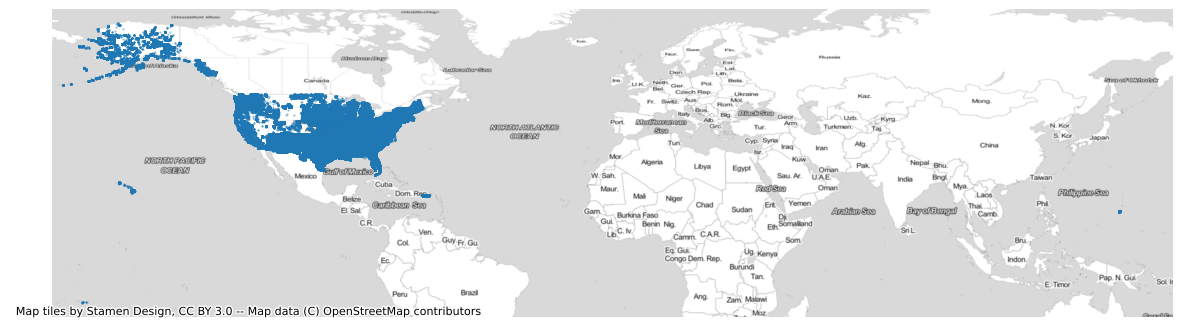

In [12]:
ax = gdf.plot(marker='.', markersize = 1, figsize=(15,9), alpha=.5)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax = ax.axis('off')

As you can see there are challenges from all over the US and the territories.


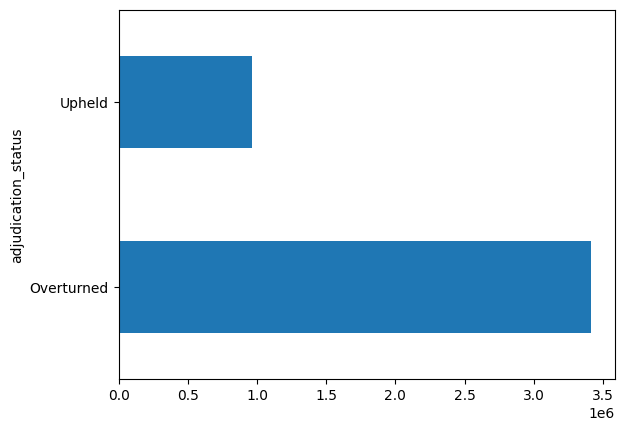

In [13]:
ax = df.adjudication_status.value_counts().plot.barh()

In [14]:
itables.show(df.adjudication_status.value_counts())

Lets see where these challenges came from.

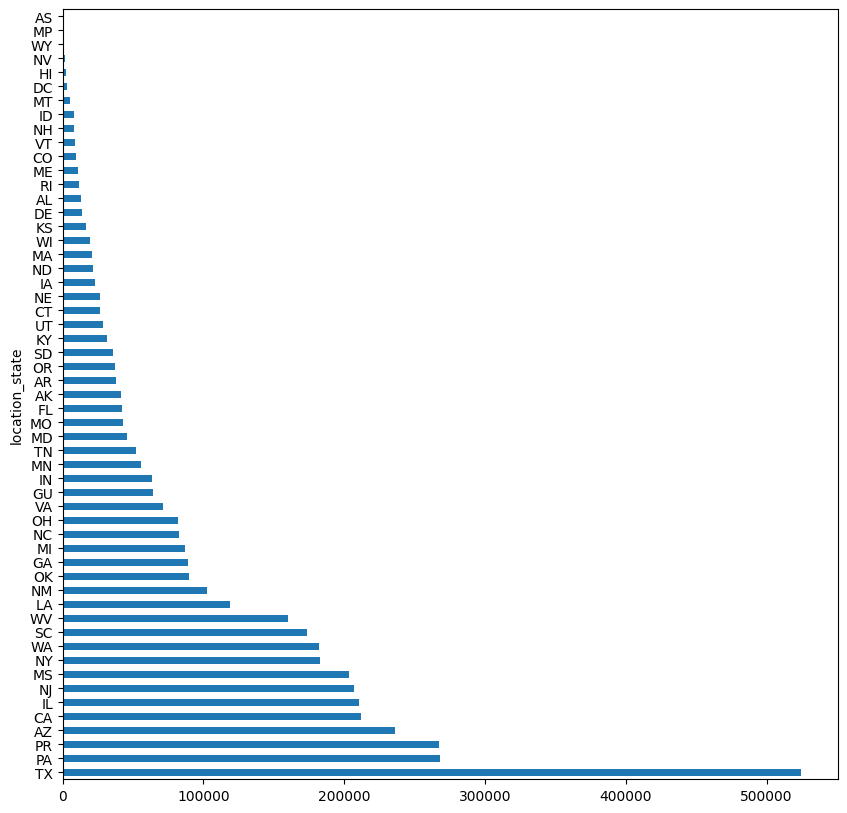

In [15]:
ax = df.location_state.value_counts().plot.barh(figsize = (10,10))

And lets look at the top 10 states that had challenges that were overturned.

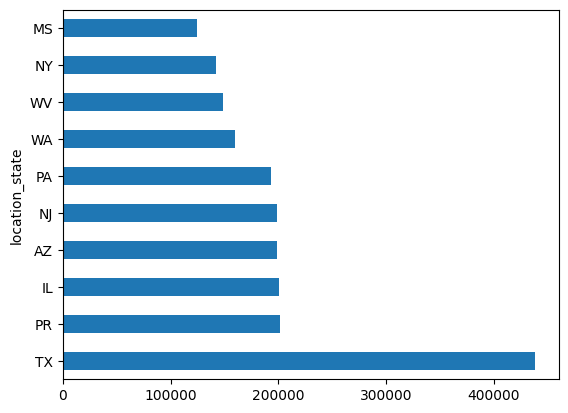

In [16]:
ax = df[df.adjudication_status=='Overturned'].location_state.value_counts().head(10).plot.barh()

And the top 10 upheld.

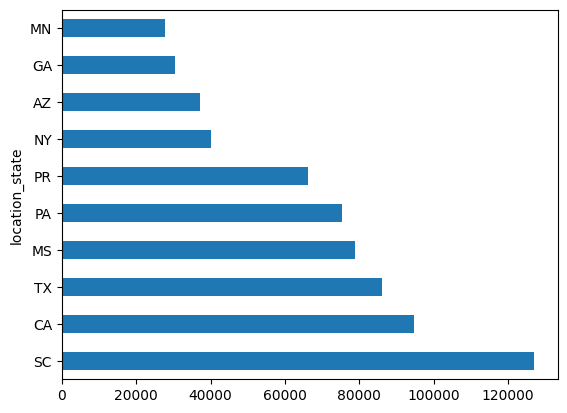

In [17]:
ax = df[df.adjudication_status=='Upheld'].location_state.value_counts().head(10).plot.barh()

## Overturned Review

One quick item we wanted to look at was the adjudication codes of overturned challenges.

In [18]:
overturned = df[df.adjudication_status=='Overturned']

Let's look at the breakdown of adjudication codes.

In [19]:
itables.show(overturned.value_counts('adjudication_code_desc'))

In [20]:
itables.show(overturned.value_counts('category_code_desc'))

## State Deep Dive Tool

Feel free to change the state in the selector below to look at a different state.

In [21]:
stateDf = df[df.location_state == 'PA']

<Axes: ylabel='adjudication_status'>

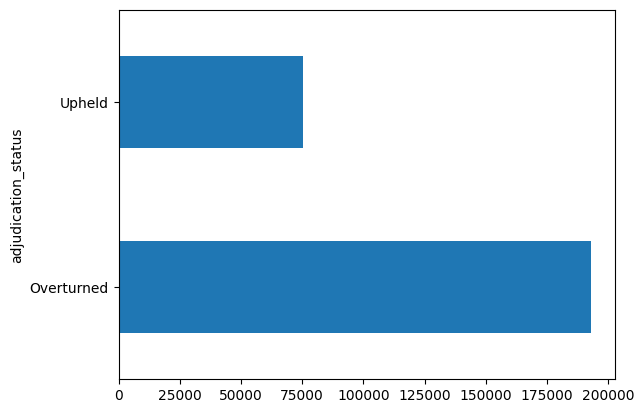

In [22]:
stateDf.value_counts('adjudication_status').plot.barh()

In [23]:
itables.show(stateDf[stateDf.adjudication_status == 'Overturned'].value_counts('adjudication_code_desc'))

In [24]:
stateGdf = gpd.GeoDataFrame(stateDf[stateDf.longitude.notna() & stateDf.latitude.notna()]).reset_index()
stateGdf = stateGdf.set_geometry(gpd.points_from_xy(stateGdf.longitude, stateGdf.latitude), crs='EPSG:4326')

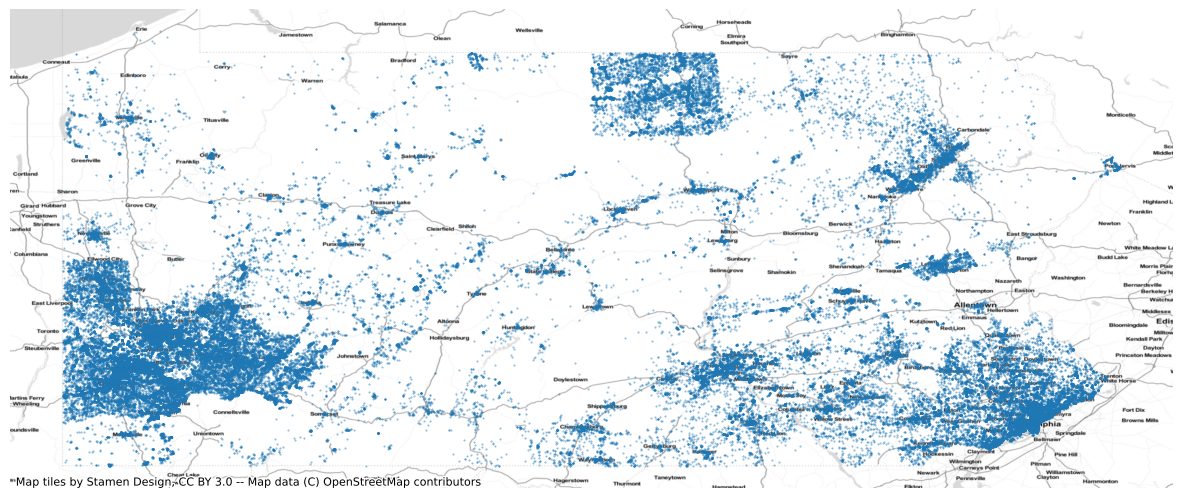

In [25]:
ax = stateGdf.plot(marker='.', markersize = 1, figsize=(15,9), alpha=.5)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax = ax.axis('off')

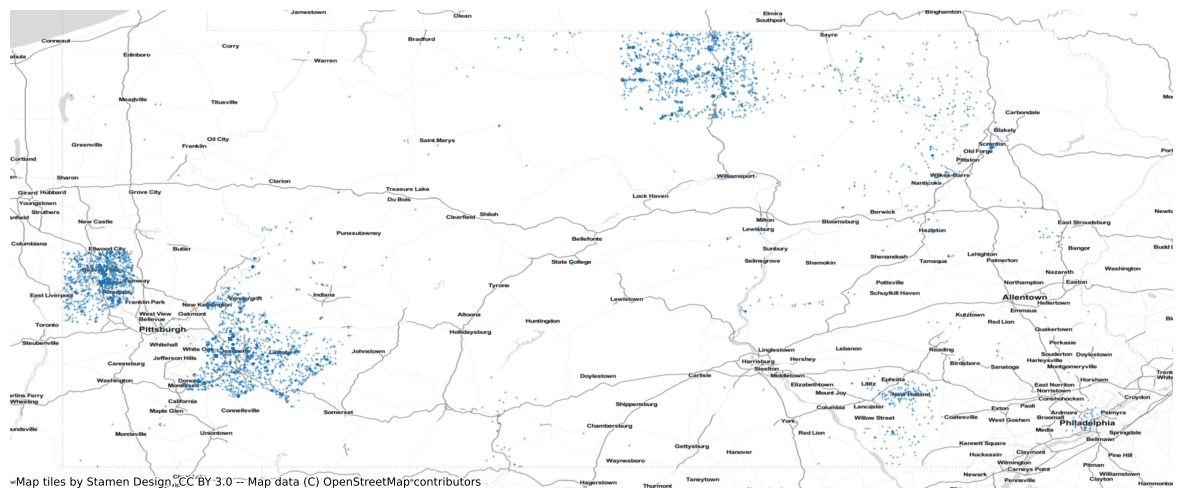

In [26]:
ax = stateGdf[stateGdf.adjudication_status == "Upheld"].plot(marker='.', markersize = 1, figsize=(15,9), alpha=.5)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax = ax.axis('off')

In [27]:
# stateGdf[stateGdf.adjudication_status == "Upheld"].explore()

In [28]:
# stateGdf[stateGdf.adjudication_status == "Overturned"].explore()

In [29]:
overturned = stateDf[stateDf.adjudication_status == 'Overturned']

In [30]:
itables.show(overturned.value_counts('adjudication_code'))

<Axes: ylabel='date_received'>

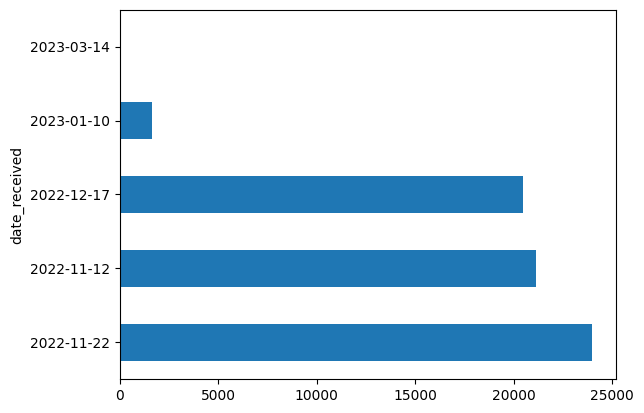

In [31]:
overturned[overturned.adjudication_code == 1.25].value_counts('date_received').plot.barh()

In [41]:
overturned.groupby(['date_received', 'adjudication_code_desc']).size().reset_index().rename(columns={0:"count"})

,date_received,adjudication_code_desc,count
0,2022-11-08,The challenge duplicated a previously accepted...,39
1,2022-11-12,BSL confirmed: The geographic coordinates for ...,7399
2,2022-11-12,The address provided for the challenge could n...,192
3,2022-11-12,The address provided for the challenge is a du...,848
4,2022-11-12,The challenge attempts to add another BSL with...,68
...,...,...,...
360,2023-03-15,The challenge attempted to add another BSL to ...,2332
361,2023-03-15,The challenge did not pass the manual review p...,9
362,2023-03-15,The challenge was overtaken by new data as ref...,71
363,2023-03-15,The geographic coordinates provided with the c...,515


In [33]:
overturned

,challenge_id,fabric_vintage,category_code,category_code_desc,location_id,location_state,address_primary,city,state,zip_code,...,address_id,latitude,longitude,date_received,withdraw_date,adjudication_status,adjudication_date,adjudication_code,adjudication_code_desc,fabric_response_location_id
2575312,16122238,2022-06-30,4,Incorrect Location Building Type,1.023911e+09,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-08,NaN,Overturned,2023-07-03,4.6,The challenge duplicated a previously accepted...,NaN
2575313,16133200,2022-06-30,4,Incorrect Location Building Type,1.102801e+09,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-08,NaN,Overturned,2023-07-03,4.6,The challenge duplicated a previously accepted...,NaN
2575314,16141079,2022-06-30,4,Incorrect Location Building Type,1.294959e+09,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-08,NaN,Overturned,2023-07-03,4.6,The challenge duplicated a previously accepted...,NaN
2575315,16141080,2022-06-30,4,Incorrect Location Building Type,1.294959e+09,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-08,NaN,Overturned,2023-07-03,4.6,The challenge duplicated a previously accepted...,NaN
2575316,16141081,2022-06-30,4,Incorrect Location Building Type,1.294961e+09,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-08,NaN,Overturned,2023-07-03,4.6,The challenge duplicated a previously accepted...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843202,24941363,2022-12-31,1,Missing Broadband Serviceable Location,NaN,PA,3434 GARVERS FERRY RD,VANDERGRIFT,PA,15690,...,NaN,40.614117,-79.545665,2023-03-15,NaN,Overturned,2023-07-03,1.7,The challenge attempted to add another BSL to ...,NaN
2843204,24941365,2022-12-31,1,Missing Broadband Serviceable Location,NaN,PA,702 N MCKEAN ST,KITTANNING,PA,16201,...,NaN,40.821348,-79.524729,2023-03-15,NaN,Overturned,2023-07-03,1.3,BSL confirmed: The geographic coordinates for ...,NaN
2843205,24941366,2022-12-31,1,Missing Broadband Serviceable Location,NaN,PA,535 1ST ST,ERNEST,PA,15739,...,NaN,40.675806,-79.162481,2023-03-15,NaN,Overturned,2023-07-03,1.5,The challenge did not pass the manual review p...,NaN
2843621,25500036,2022-12-31,2,Incorrect Location Address,1.024509e+09,PA,100 NEAL RD,MARION CENTER,PA,15759,...,NaN,NaN,NaN,2023-03-15,NaN,Overturned,2023-07-03,2.2,The address provided for the challenge could n...,NaN


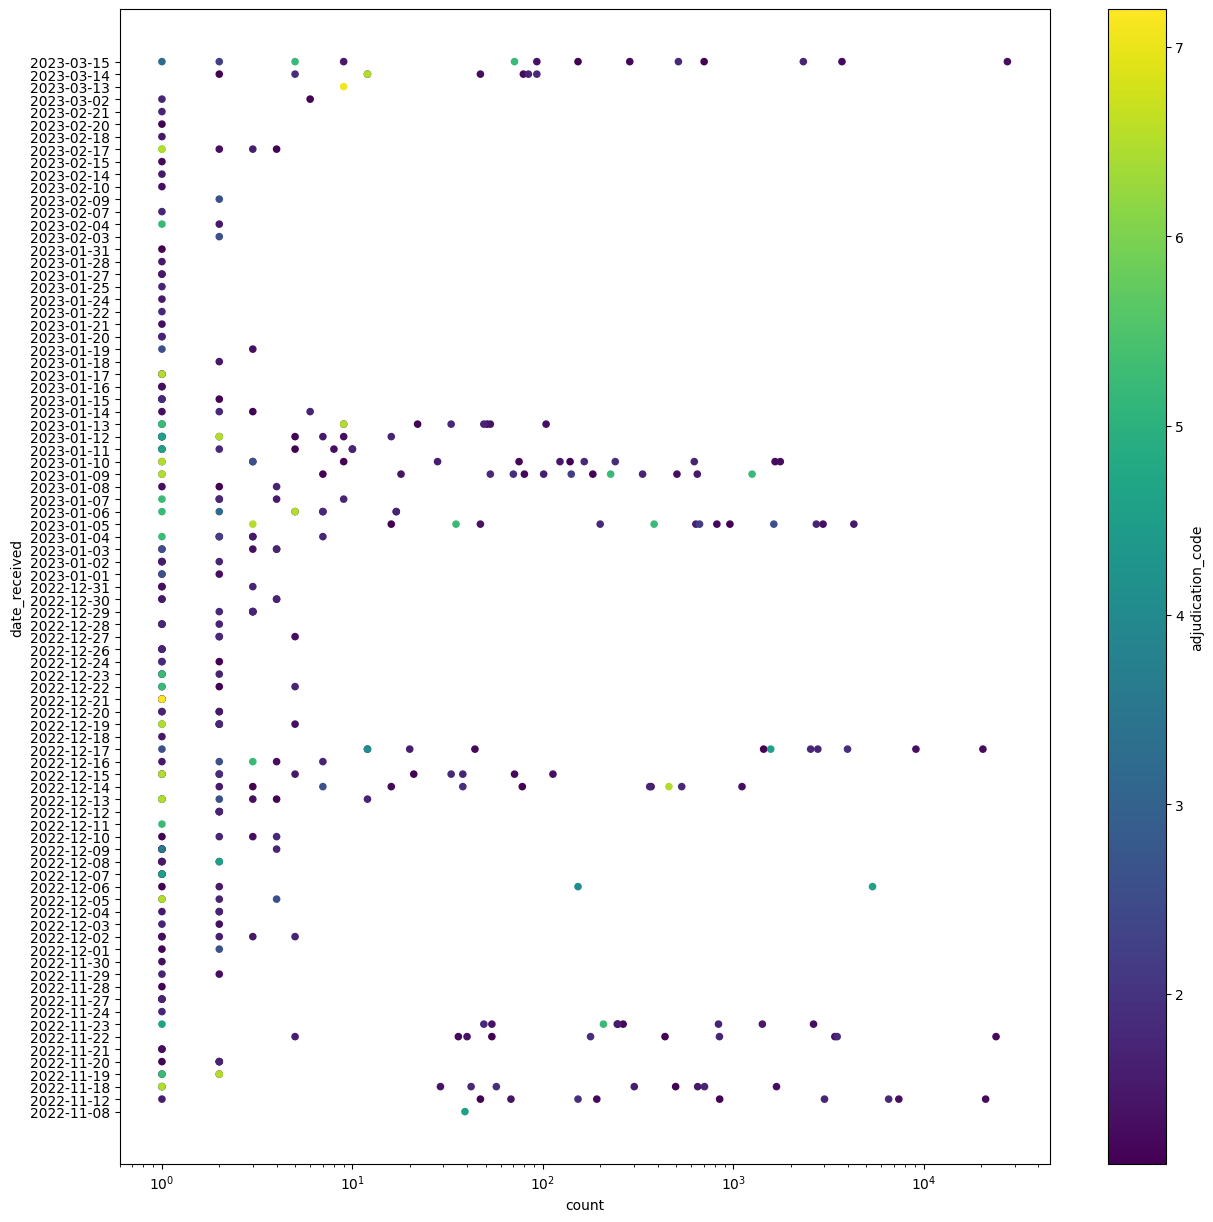

In [34]:
# overturned.groupby(['date_received', 'adjudication_code']).size().plot.scatter(x='date_received')
ax = overturned.groupby(['date_received', 'adjudication_code']).size().reset_index().rename(columns={0:"count"}).plot.scatter(y='date_received', c='adjudication_code', x='count', figsize=(15,15))
ax.set_xscale('log')

## Conclusion

My hat's off to South Carolina. Way to go get a ton of upheld challenges!

This is my first time looking at this dataset. Please suggest updates and other information that you would like to see by filing a GitHub issue [here](https://github.com/bbcommons/challengeReview-Jul23/issues) describing what you would like to see. I am happy to run further breakdowns.

## References

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4378953 entries, 0 to 4378952
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   challenge_id                 int64  
 1   fabric_vintage               object 
 2   category_code                int64  
 3   category_code_desc           object 
 4   location_id                  float64
 5   location_state               object 
 6   address_primary              object 
 7   city                         object 
 8   state                        object 
 9   zip_code                     object 
 10  zip_code_suffix              object 
 11  unit_count                   float64
 12  building_type_code           object 
 13  non_bsl_code                 object 
 14  bsl_lacks_address_flag       float64
 15  address_id                   float64
 16  latitude                     float64
 17  longitude                    float64
 18  date_received                object 
 19  